# Modules used in this project

In [149]:
# standard libraries
import os
import time
from datetime import datetime
import itertools
from itertools import chain, combinations
import warnings
warnings.filterwarnings('ignore')

# data analysis and manipulation
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning and model selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor

# statistical tools and analysis
from scipy.stats import pearsonr, shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# APIs and requests
import requests
import json

import time

pd.set_option('display.float_format', '{:.2f}'.format)  # Define 6 casas decimais

# Functions used in this project

## Data visualization

In [150]:
def autocorrelation(df, n_lags, autocorrelation_function="ACF", 
                    output_file=r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\Autocorrelação\ACF_function.xlsx"):
    """
    Função para calcular a autocorrelação (ACF) manualmente e salvar os resultados em um arquivo Excel.
    
    Parâmetros:
    df : DataFrame
        DataFrame contendo as séries temporais.
    n_lags : int
        Número de lags (defasagens) para calcular.
    autocorrelation_function : str
        'ACF' para autocorrelação ou 'PACF' para autocorrelação parcial.
    output_file : str
        Caminho e nome do arquivo Excel para salvar os resultados.
        
    Retorna:
    None
    """
    # Inicializa um dicionário para armazenar os resultados
    results = {column: [] for column in df.columns}
    
    # Loop sobre as colunas (séries temporais)
    for column in df.columns:
        y = df[column].values
        mean_y = np.mean(y)  # Média da série
        
        # Calculando a autocorrelação para cada lag
        for k in range(1, n_lags + 1):
            numerator = np.sum((y[k:] - mean_y) * (y[:-k] - mean_y))  # Somatório do numerador
            denominator = np.sum((y - mean_y) ** 2)  # Somatório do denominador
            acf_value = numerator / denominator
            results[column].append(acf_value)
    
    # Criar o DataFrame com os resultados
    acf_df = pd.DataFrame(results, index=range(1, n_lags + 1))
    
    # Salvar o DataFrame como um arquivo Excel
    acf_df.to_excel(output_file)
    print(f"Autocorrelação salva no arquivo {output_file}")

In [151]:
def scatter_plots(df):
    columns = df.columns
    combinations = list(itertools.combinations(columns, 2))  
    for col1, col2 in combinations:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col1], y=df[col2])
        plt.title(f'Scatter Plot: {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(True)
        plt.show()

In [152]:
def plot_residuals(residuals_df):
    num_columns = len(residuals_df.columns)
    
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, 6 * num_columns), sharex=True)
    
    for i, column in enumerate(residuals_df.columns):
        axes[i].plot(residuals_df.index, residuals_df[column], label=f'Resíduo - {column}')
        axes[i].axhline(0, color='black', linewidth=1)
        axes[i].set_ylabel('Resíduos')
        axes[i].set_title(f'Resíduos - {column}')
        axes[i].legend()
    
    axes[-1].set_xlabel('Tempo')  
    plt.tight_layout()  
    plt.show()

In [153]:
def plot_autocorrelation(df, n_lags, autocorrelation_function):

    if autocorrelation_function == "ACF":
        for column in df.columns:
            plot_acf(df[column], lags = n_lags)
            plt.title(f"ACF for {column}")
            plt.tight_layout() 
            
    elif autocorrelation_function == "PACF":
        for column in df.columns:
                plot_pacf(df[column], lags = n_lags)
                plt.title(f"PACF for {column}")
                plt.tight_layout()
            
    else:
        print("Invalid autocorrelation function. Please try 'ACF' or 'PACF'")

## Statistics and data analysis

In [154]:
def correlation_with_lags(target_series, series_dict, max_lag):
    correlations = {}
    
    # Iterar sobre cada série no dicionário
    for series_name, other_series in series_dict.items():
        
        # Dicionário para armazenar as correlações de uma única série
        series_correlations = {}
        
        for lag in range(max_lag + 1):
            # Defasagem da outra série
            shifted_series = other_series.shift(lag)
            
            # Calcular correlação entre a série alvo e a série defasada
            correlation = target_series.corr(shifted_series)
            
            # Armazenar a correlação com o nome da coluna correspondente ao lag
            series_correlations[f'corr_lag_{lag}'] = correlation
        
        # Armazenar as correlações dessa série
        correlations[series_name] = series_correlations
    
    # Converter o dicionário em DataFrame
    result_df = pd.DataFrame(correlations).T 
    
    return result_df

In [155]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("A série não é estacionária (p > 0.05)")
    else:
        print("A série é estacionária (p <= 0.05)")

In [156]:
def shapiro_test(residuals_df):
    for column in residuals_df.columns:
        stat, p_value = shapiro(residuals_df[column])
        if p_value < 0.05:
            print(f"Variável: {column}, estatística: {stat}, p-value: {p_value}. Hipótese nula rejeitada. Os resíduos não são normalmente distribuídos")
        else: 
            print(f"Variável: {column}, estatística: {stat}, p-value: {p_value}. Hipótese nula não foi rejeitada. Os resíduos são normalmente distribuídos")

## Data preprocessing and manipulation

In [157]:
def split_train_test(X, y, train_size=0.8):
    split_index = int(len(X) * train_size)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    return X_train, X_test, y_train, y_test

In [158]:
def convert_unix_milliseconds_to_date(unix_milliseconds):
    # Convert milliseconds to seconds
    unix_seconds = unix_milliseconds / 1000
    # Create a datetime object from the Unix timestamp
    dt = datetime.fromtimestamp(unix_seconds)
    # Format the datetime object to a string in day/month/year format
    return dt.strftime('%d/%m/%Y')

In [159]:
def convert_to_date(df, date_column, freq='h'):
    df = df.assign(date=list(map(lambda x: convert_unix_milliseconds_to_date(x), 
                                        df[date_column])))
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    df['hour'] = pd.date_range(start='00:00', periods=len(df), freq=freq).time
    df['date_hour'] = df['date'] + pd.to_timedelta(df.groupby('date').cumcount(), unit=freq)
    df.index = df['date_hour']
    df = df.drop('date_hour', axis=1)
    return df

In [160]:
def get_all_combinations(columns):
    return list(chain.from_iterable(combinations(columns, r) for r in range(1, len(columns) + 1)))

In [161]:
def add_lags(df, num_lags):
    
    lagged_df = df.copy()

    for lag in range(1, num_lags + 1):
        lagged_columns = {
            f"{col}_lag_{lag}": df[col].shift(lag)
            for col in df.columns
        }
        lagged_df = pd.concat([lagged_df, pd.DataFrame(lagged_columns)], axis=1)

    lagged_df.dropna(inplace=True)

    return lagged_df

## Model training

In [162]:
def one_step_ahead_forecasting(X, y, model, starting_point):
    '''predict the next observation of a time series using as training set all the past observations'''
    
    predictions = np.array([])
    print('Treinando')
    X_train, X_test, y_train, y_test = training_test_split(X, y, starting_point = starting_point)
    print('Fit')
    model.fit(X_train.values, y_train.values)
    print('Fit final')
    for i in range(len(X_test)):
        predictions = np.append(predictions, (model.predict(X_test.iloc[i].values.reshape(1, -1))))
        print('Predição')
        X_train = pd.concat([X_train, X_test.iloc[i].to_frame().T])
        y_train = np.append(y_train, y_test.iloc[i].reshape(1, -1))
        
        y_train = pd.Series(y_train)
        
        model.fit(X_train.values, y_train.values)
        
    return predictions

In [239]:
def one_step_ahead_forecasting_AR(y, starting_point_percent, lags):
    '''Faz previsão one-step-ahead utilizando modelo autoregressivo (AR) e um ponto de início baseado em porcentagem'''
    
    predictions = np.array([])
    phi_values = []  # Lista para armazenar os coeficientes autoregressivos e o intercepto
    
    print(f'Treinando modelo AR com {lags} lags')

    # Definindo o ponto de início como porcentagem dos dados
    starting_point = int(len(y) * starting_point_percent)
    
    # Dividindo o conjunto de treino e teste a partir do ponto de início
    y_train = y[:starting_point]
    y_test = y[starting_point:]

    # Criando o modelo autoregressivo inicial
    model = AutoReg(y_train, lags=lags)
    model_fit = model.fit()

    # Adicionando todos os parâmetros (incluindo o intercepto)
    phi_values.append(model_fit.params[:].tolist())  # Mantendo o intercepto

    # Previsão one-step-ahead
    for i in range(len(y_test)):
        # Prevendo o próximo valor (one-step-ahead)
        pred = model_fit.predict(start=len(y_train), end=len(y_train), dynamic=False)
        predictions = np.append(predictions, pred)
        
        # Adiciona o valor real ao conjunto de treino
        y_train = np.append(y_train, y_test.iloc[i])
        
        # Ajusta o modelo novamente com o novo valor adicionado
        model = AutoReg(y_train, lags=lags)
        model_fit = model.fit()
        
        # Armazenando todos os coeficientes (incluindo o intercepto)
        phi_values.append(model_fit.params[:].tolist())  # Mantendo o intercepto

    return predictions, phi_values

In [240]:
def fit_ar_model(df, starting_point_percent, lags_list):
    '''Treina o modelo AR com uma lista de lags e retorna DataFrames de performance, resíduos e coeficientes autoregressivos'''
    
    performance_dict = {}
    residuals_dict = {}
    phi_dict = {}  # Dicionário para armazenar os coeficientes autoregressivos

    for lags in lags_list:
        print(f'Treinando para {lags} lags')
        
        for column in df.columns:
            print(f'Treinando com a variável: {column}')
            
            # Previsão com AR
            predictions, phi_values = one_step_ahead_forecasting_AR(
                y=df[column], 
                starting_point_percent=starting_point_percent, 
                lags=lags
            )
            
            # Avaliando a performance
            actual = df[column].iloc[int(len(df[column]) * starting_point_percent):]
            mse, mae = evaluate_performance(predictions=predictions, actual=actual)
            performance_dict[(column, lags)] = [mse, mae]

            # Calculando os resíduos
            residuals = predictions - actual.to_numpy()
            residuals_dict[(column, lags)] = residuals

            # Modelo Naive: previsão t = valor de t-1 para a variável
            predictions_naive = df[column].shift(1).iloc[int(len(df[column]) * starting_point_percent):]
            predictions_naive = predictions_naive.dropna()
            mse_naive, mae_naive = evaluate_performance(predictions=predictions_naive, actual=actual)
            performance_dict[('Naive_' + column, lags)] = [mse_naive, mae_naive]
            
            # Armazenando os coeficientes autoregressivos corretamente
            phi_dict[(column, lags)] = np.array(phi_values)  # Converte lista para numpy array

    # Convertendo os dicionários de performance e resíduos para DataFrames
    performance_df = pd.DataFrame.from_dict(performance_dict, orient='index', columns=['MSE', 'MAE'])
    performance_df.index = pd.MultiIndex.from_tuples(performance_df.index, names=["Variable", "Lags"])
    
    residuals_df = pd.DataFrame.from_dict(residuals_dict)
    residuals_df.columns = pd.MultiIndex.from_tuples(residuals_df.columns, names=["Variable", "Lags"])
    residuals_df.index = df.index[int(len(df) * starting_point_percent) : int(len(df) * starting_point_percent) + len(residuals_df)]
    
    # Criando DataFrame de coeficientes autoregressivos corretamente
    phi_df = pd.DataFrame.from_dict(phi_dict, orient='index')

    # Ajustando colunas para refletirem o intercepto e os lags
    num_lags = max(lags_list)  # Pegamos o maior lag para definir colunas corretamente
    phi_columns = ['Intercept'] + [f'Lag_{i}' for i in range(1, num_lags + 1)]

    # Ajustando as colunas do DataFrame
    phi_df = phi_df.apply(lambda x: x.explode()).reset_index()
    phi_df = phi_df.drop(columns=["index"])
    
    # Renomeando as colunas corretamente
    phi_df.columns = phi_columns[:phi_df.shape[1]]

    # Ajustando o índice
    phi_df.index = pd.MultiIndex.from_tuples(phi_dict.keys(), names=["Variable", "Lags"])

    return performance_df, residuals_df, phi_df

In [275]:
def one_step_ahead_forecasting_AR_exog(y, X, starting_point_percent, lags):
    """Faz previsão one-step-ahead utilizando modelo autoregressivo (AR) com variáveis exógenas e lags e retorna os coeficientes."""
    predictions = []
    coefficients_list = []
    phi_values = []
    phi_dict = {}

    print('Treinando modelo AR com variáveis exógenas e lags')

    # Definir o ponto de início
    starting_point = int(len(y) * starting_point_percent)

    # Dividindo o conjunto de treino e teste
    y_train = y[:starting_point].values  # Convertendo para numpy array
    y_test = y[starting_point:].values  # Convertendo para numpy array

    X_train = np.array(X.iloc[:starting_point]).reshape(len(X.iloc[:starting_point]), -1)
    X_test = np.array(X.iloc[starting_point:]).reshape(len(X.iloc[starting_point:]), -1)

    # Criar e ajustar o modelo inicial
    model = AutoReg(y_train, lags=lags, exog=X_train)
    model_fit = model.fit()
    print('Modelo ajustado')

    phi_values.append(model_fit.params.tolist())

    for i in range(len(y_test)):
        print(f'Predição passo {i+1}')

        if i >= len(X_test):  # Evita erro de indexação
            break

        exog_oos = X_test[i].reshape(1, -1)  # Converter exógenos para 2D corretamente
        pred = model_fit.predict(start=len(y_train), end=len(y_train), exog_oos=exog_oos, dynamic=False)

        if pred.size > 0:
            predictions.append(pred[0])
        else:
            predictions.append(np.nan)  # Evita erro caso a previsão falhe

        # Salvar os coeficientes do modelo
        phi_values.append(model_fit.params.tolist())
        phi_dict[(tuple(X.columns), lags)] = np.array(phi_values)

        # Atualizar conjunto de treino
        y_train = np.append(y_train, y_test[i])
        X_train = np.vstack([X_train, X_test[i].reshape(1, -1)])

        # Ajustar modelo novamente
        model = AutoReg(y_train, lags=lags, exog=X_train)
        model_fit = model.fit()

    return np.array(predictions), phi_values, phi_dict

In [276]:
def fit_ar_model_exog(df, target_column, starting_point_percent, lags_list):
    """Treina o modelo AR com variáveis exógenas para diferentes lags e retorna DataFrames de performance, resíduos e coeficientes."""
    performance_dict = {}
    residuals_dict = {}
    phi_dict = {}

    y = df[target_column]
    X = df.drop(target_column, axis=1)

    # Gerar todas as combinações possíveis das variáveis exógenas
    exog_combinations = get_all_combinations(X.columns)

    for lags in lags_list:
        print(f'Treinando para {lags} lags')

        for combo in exog_combinations:
            print(f'Treinando com variáveis exógenas: {combo}')

            X_subset = X[list(combo)]  # Seleciona as colunas da combinação

            predictions, phi_values, phi = one_step_ahead_forecasting_AR_exog(
                y=y, X=X_subset, starting_point_percent=starting_point_percent, lags=lags
            )

            actual = y.iloc[int(len(y) * starting_point_percent):].values
            actual = actual[:len(predictions)]  # Garantir tamanhos compatíveis

            if len(predictions) != len(actual):
                print(f"Inconsistência de tamanho! Predictions: {len(predictions)}, Actual: {len(actual)}")
                continue

            mse, mae = evaluate_performance(predictions=predictions, actual=actual)
            performance_dict[(combo, lags)] = [mse, mae]

            residuals = predictions - actual
            residuals_dict[(combo, lags)] = residuals

            # Salvar coeficientes estimados
            phi_dict.update(phi)

            # Modelo Naive
            predictions_naive = y.shift(1).iloc[int(len(y) * starting_point_percent):].dropna().values
            predictions_naive = predictions_naive[:len(actual)]

            if len(predictions_naive) != len(actual):
                continue

            mse_naive, mae_naive = evaluate_performance(predictions=predictions_naive, actual=actual)
            performance_dict[('Naive_' + '_'.join(combo), lags)] = [mse_naive, mae_naive]

    # Convertendo os dicionários de performance e resíduos para DataFrames
    performance_df = pd.DataFrame.from_dict(performance_dict, orient='index', columns=['MSE', 'MAE'])
    performance_df.index = pd.MultiIndex.from_tuples(performance_df.index, names=["Variables", "Lags"])

    residuals_df = pd.DataFrame.from_dict(residuals_dict)
    residuals_df.columns = pd.MultiIndex.from_tuples(residuals_df.columns, names=["Variables", "Lags"])
    residuals_df.index = y.iloc[int(len(y) * starting_point_percent):].index[:len(residuals_df)]

    # Convertendo coeficientes para DataFrame
    phi_df = pd.DataFrame.from_dict(phi_dict, orient='index')
    phi_df.index = pd.MultiIndex.from_tuples(phi_df.index, names=["Variables", "Lags"])

    return performance_df, residuals_df, phi_df

## Model validation

In [167]:
def time_series_cross_validation(X_train, y_train, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    errors = []

    # Iniciar o contador de tempo
    start_time = time.time()

    for train_index, val_index in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_t, y_t)
        predictions = model.predict(X_val)

        mse = mean_squared_error(y_val, predictions)
        errors.append(mse)

    # Finalizar o contador de tempo
    end_time = time.time()
    total_time = end_time - start_time

    # Exibir o tempo total de treinamento
    print(f"Total training time: {total_time:.2f} seconds")

    return np.mean(errors)

In [168]:
def hyperparameter_optimization(X_train, y_train, model, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        print(f"Testando a combinação {params}")
        model.set_params(**params)
        mse = time_series_cross_validation(X_train, y_train, model, n_splits=5)

        result = params.copy()
        result["mse"] = mse
        results.append(result)
    return pd.DataFrame(results)

In [169]:
def final_model_evaluation(X_train, y_train, X_test, y_test, model, best_params):
    """
    Trains the model on the training data and evaluates on the test set.
    Filters out invalid hyperparameters before setting them.
    """
    # Get valid hyperparameters for the model
    valid_params = model.get_params().keys()
    
    # Filter only valid hyperparameters
    filtered_params = {k: v for k, v in best_params.items() if k in valid_params}

    # Set the valid hyperparameters
    model.set_params(**filtered_params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)

    # Calculate MSE
    final_mse = mean_squared_error(y_test, predictions)
    
    return final_mse, predictions

In [170]:
def optimize_and_evaluate(X, y, models_and_params):
    X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.8)
    all_results = pd.DataFrame()

    for model_name, model_info in models_and_params.items():
        print(f"Otimizando {model_name}...")
        results_df = hyperparameter_optimization(
            X_train, y_train, model_info["model"], model_info["params"]
        )
        results_df["model"] = model_name

        best_params = results_df.sort_values(by="mse").iloc[0].drop("mse").to_dict()
        final_mse, predictions = final_model_evaluation(
            X_train, y_train, X_test, y_test, model_info["model"], best_params
        )

        print(f"{model_name} - MSE Final no Teste: {final_mse:.4f}")
        results_df["final_test_mse"] = final_mse
        all_results = pd.concat([all_results, results_df], ignore_index=True)

    return all_results

In [171]:
def optimize_and_evaluate_one_lag(df, models_and_params):
    all_results = pd.DataFrame()

    for column in df.columns:
        print(f"\n🔍 Processing column: {column}")

        # Create lagged feature (lag 1)
        lagged_df = pd.DataFrame({
            f"{column}_lag_1": df[column].shift(1),
            column: df[column]
        }).dropna()

        # Define X and y
        X = lagged_df[[f"{column}_lag_1"]]
        y = lagged_df[column]

        # Split into train and test sets
        X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.8)

        # Apply models to each column
        for model_name, model_info in models_and_params.items():
            print(f"⚙️ Optimizing model: {model_name} for {column}")

            # Hyperparameter optimization
            results_df = hyperparameter_optimization(
                X_train, y_train, model_info["model"], model_info["params"]
            )
            results_df["model"] = model_name
            results_df["series"] = column

            # Best hyperparameters
            best_params = results_df.sort_values(by="mse").iloc[0].drop("mse").to_dict()

            # Final evaluation
            final_mse, predictions = final_model_evaluation(
                X_train, y_train, X_test, y_test, model_info["model"], best_params
            )

            print(f"✅ {model_name} for {column} - Final MSE on Test: {final_mse:.4f}")

            # Store results
            results_df["final_test_mse"] = final_mse
            all_results = pd.concat([all_results, results_df], ignore_index=True)

    return all_results

In [172]:
def evaluate_all_feature_combinations(df, target, exogenous_vars, model, param_grid):
    results = pd.DataFrame()

    # Generate all possible combinations of exogenous variables + lagged target
    all_features = [f"{target}_lag_1"] + exogenous_vars
    feature_combinations = []
    for i in range(1, len(all_features) + 1):
        feature_combinations.extend(combinations(all_features, i))

    # Loop through all feature combinations
    for feature_set in feature_combinations:
        print(f"\n🔍 Evaluating feature set: {feature_set}")
        X = df[list(feature_set)]
        y = df[target]
        
        # Drop rows with NaNs caused by lags
        data = pd.concat([X, y], axis=1).dropna()
        X = data[list(feature_set)]
        y = data[target]

        # Train-test split
        X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.8)

        # Optimize hyperparameters for the current feature set
        results_df = hyperparameter_optimization(X_train, y_train, model, param_grid)
        results_df["features"] = [feature_set] * len(results_df)

        # Get best hyperparameters based on MSE
        best_params = results_df.sort_values(by="mse").iloc[0].drop("mse").to_dict()
        final_mse, predictions = final_model_evaluation(
            X_train, y_train, X_test, y_test, model, best_params
        )

        print(f"✅ Features: {feature_set} - Final MSE on Test: {final_mse:.4f}")
        results_df["final_test_mse"] = final_mse

        # Store the results
        results = pd.concat([results, results_df], ignore_index=True)

    return results

In [173]:
def final_model_evaluation(X_train, y_train, X_test, y_test, model, best_params):
    valid_params = model.get_params().keys()
    
    # Filter valid hyperparameters
    filtered_params = {k: v for k, v in best_params.items() if k in valid_params}

    # Convert floats to integers if necessary
    integer_params = [
        'max_depth', 'max_leaf_nodes', 'min_samples_split', 'min_samples_leaf', 'n_estimators'
    ]
    for param in integer_params:
        if param in filtered_params and isinstance(filtered_params[param], float):
            filtered_params[param] = int(filtered_params[param])

    # Train the model
    model.set_params(**filtered_params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    final_mse = mean_squared_error(y_test, predictions)

    return final_mse, predictions

## Model evaluation

In [174]:
def evaluate_performance(predictions, actual):
    '''Evaluates model's performance using MSE, MAE e R²'''
    
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    
    return [mse, mae]

# Getting the data

In [175]:
criptos = pd.read_csv(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\input_data\cripto_data_consolidated.csv", 
                      delimiter = ";")

In [176]:
def calculate_time_series_statistics(df):    
    # Estatísticas básicas
    stats = df.describe().T  # Transpor para melhor visualização
    stats['Median'] = df.median()
    
    return stats

In [177]:
criptos

# timestamp  okx/BTC-USDT-SWAP  okx/DOGE-USDT-SWAP  \
0      1638420000000           56897.60                0.21   
1      1638420000000           56651.70                0.21   
2      1638430000000           56819.00                0.21   
3      1638430000000           56947.40                0.22   
4      1638440000000           56682.70                0.21   
...              ...                ...                 ...   
17675  1702050000000           43829.80                0.10   
17676  1702050000000           43743.40                0.10   
17677  1702060000000           43814.00                0.10   
17678  1702060000000           43956.10                0.10   
17679  1702070000000           44367.90                0.10   

       okx/LINK-USDT-SWAP  okx/XMR-USDT-SWAP  okx/SOL-USDT-SWAP  
0                   24.79             230.85             223.06  
1                   24.76             232.06             223.21  
2                   24.83             231.54             222.97  
3                   24.85             233.80             227.99  
4                   24.82             233.75             227.34  
...                   ...                ...                ...  
17675               16.62             173.10              72.85  
17676               16.70             173.20              73.64  
17677               16.61             173.00              72.77  
17678               16.78             172.90              72.29  
17679               16.84             174.30              73.40  

[17680 rows x 6 columns]

In [178]:
criptos_describe = calculate_time_series_statistics(criptos)

criptos_describe.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\criptos_describe.xlsx")

In [179]:
criptos = criptos.drop(criptos.loc[criptos.duplicated() == True].index)

In [180]:
criptos.columns = ['# timestamp', 'Bitcoin', 'Dogecoin', 'Chainlink', 'Monero', 'Solana']

In [181]:
criptos = convert_to_date(criptos, '# timestamp')

In [182]:
features = ['Bitcoin', 'Dogecoin', 'Chainlink', 'Monero', 'Solana']

In [183]:
criptos

# timestamp  Bitcoin  Dogecoin  Chainlink  Monero  \
date_hour                                                                  
2021-12-02 00:00:00  1638420000000 56897.60      0.21      24.79  230.85   
2021-12-02 01:00:00  1638420000000 56651.70      0.21      24.76  232.06   
2021-12-02 02:00:00  1638430000000 56819.00      0.21      24.83  231.54   
2021-12-02 03:00:00  1638430000000 56947.40      0.22      24.85  233.80   
2021-12-02 04:00:00  1638440000000 56682.70      0.21      24.82  233.75   
...                            ...      ...       ...        ...     ...   
2023-12-08 12:00:00  1702050000000 43829.80      0.10      16.62  173.10   
2023-12-08 13:00:00  1702050000000 43743.40      0.10      16.70  173.20   
2023-12-08 14:00:00  1702060000000 43814.00      0.10      16.61  173.00   
2023-12-08 15:00:00  1702060000000 43956.10      0.10      16.78  172.90   
2023-12-08 16:00:00  1702070000000 44367.90      0.10      16.84  174.30   

                     Solana       date      hour  
date_hour                                         
2021-12-02 00:00:00  223.06 2021-12-02  00:00:00  
2021-12-02 01:00:00  223.21 2021-12-02  01:00:00  
2021-12-02 02:00:00  222.97 2021-12-02  02:00:00  
2021-12-02 03:00:00  227.99 2021-12-02  03:00:00  
2021-12-02 04:00:00  227.34 2021-12-02  04:00:00  
...                     ...        ...       ...  
2023-12-08 12:00:00   72.85 2023-12-08  05:00:00  
2023-12-08 13:00:00   73.64 2023-12-08  06:00:00  
2023-12-08 14:00:00   72.77 2023-12-08  07:00:00  
2023-12-08 15:00:00   72.29 2023-12-08  08:00:00  
2023-12-08 16:00:00   73.40 2023-12-08  09:00:00  

[17674 rows x 8 columns]

In [184]:
criptos = criptos.drop(['# timestamp', 'date', 'hour'], axis = 1)

## Plots

### Base 100

In [185]:
criptos_base_100 = criptos[features] / criptos[features].iloc[0] * 100

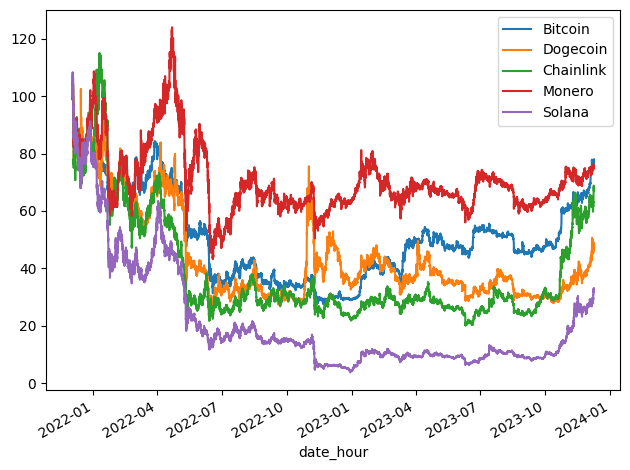

In [186]:
criptos_base_100[features].plot()

plt.tight_layout()

In [187]:
criptos_base_100.to_excel('plots/criptos_base_100.xlsx')

### Standard

In [188]:
criptos_standard = (criptos[features] - criptos[features].mean()) / criptos[features].std()

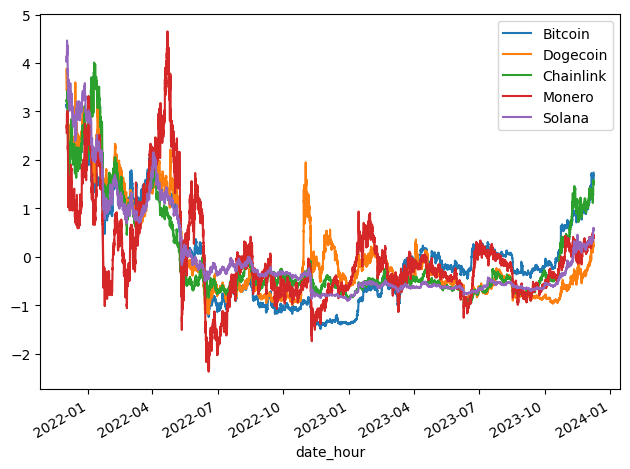

In [189]:
criptos_standard[features].plot()

plt.tight_layout()

In [190]:
criptos_standard.to_excel('plots/criptos_standard.xlsx')

### Standard with Difference

In [191]:
criptos_standard_diff = criptos_standard[features] - criptos_standard[features].shift(1)
criptos_standard_diff = criptos_standard_diff.dropna()

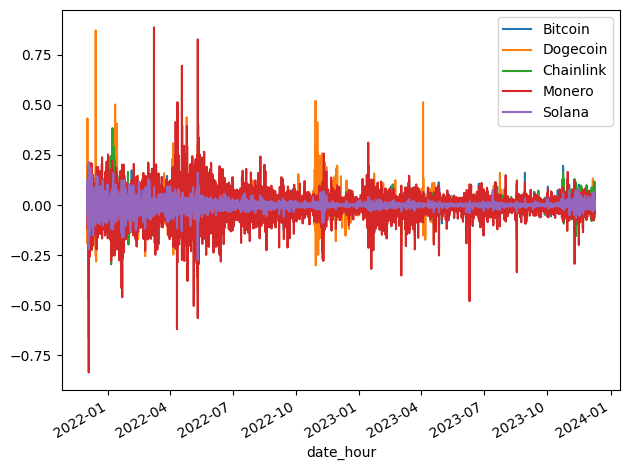

In [192]:
criptos_standard_diff[features].plot()

plt.tight_layout()

In [193]:
criptos_standard_diff.to_excel('plots/criptos_standard_diff.xlsx')

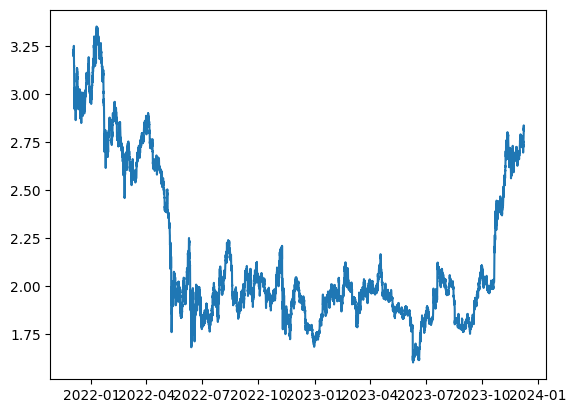

In [194]:
plt.plot(np.log(criptos.Chainlink))

## Correlations

### Scatter plots

In [195]:
criptos

Bitcoin  Dogecoin  Chainlink  Monero  Solana
date_hour                                                        
2021-12-02 00:00:00 56897.60      0.21      24.79  230.85  223.06
2021-12-02 01:00:00 56651.70      0.21      24.76  232.06  223.21
2021-12-02 02:00:00 56819.00      0.21      24.83  231.54  222.97
2021-12-02 03:00:00 56947.40      0.22      24.85  233.80  227.99
2021-12-02 04:00:00 56682.70      0.21      24.82  233.75  227.34
...                      ...       ...        ...     ...     ...
2023-12-08 12:00:00 43829.80      0.10      16.62  173.10   72.85
2023-12-08 13:00:00 43743.40      0.10      16.70  173.20   73.64
2023-12-08 14:00:00 43814.00      0.10      16.61  173.00   72.77
2023-12-08 15:00:00 43956.10      0.10      16.78  172.90   72.29
2023-12-08 16:00:00 44367.90      0.10      16.84  174.30   73.40

[17674 rows x 5 columns]

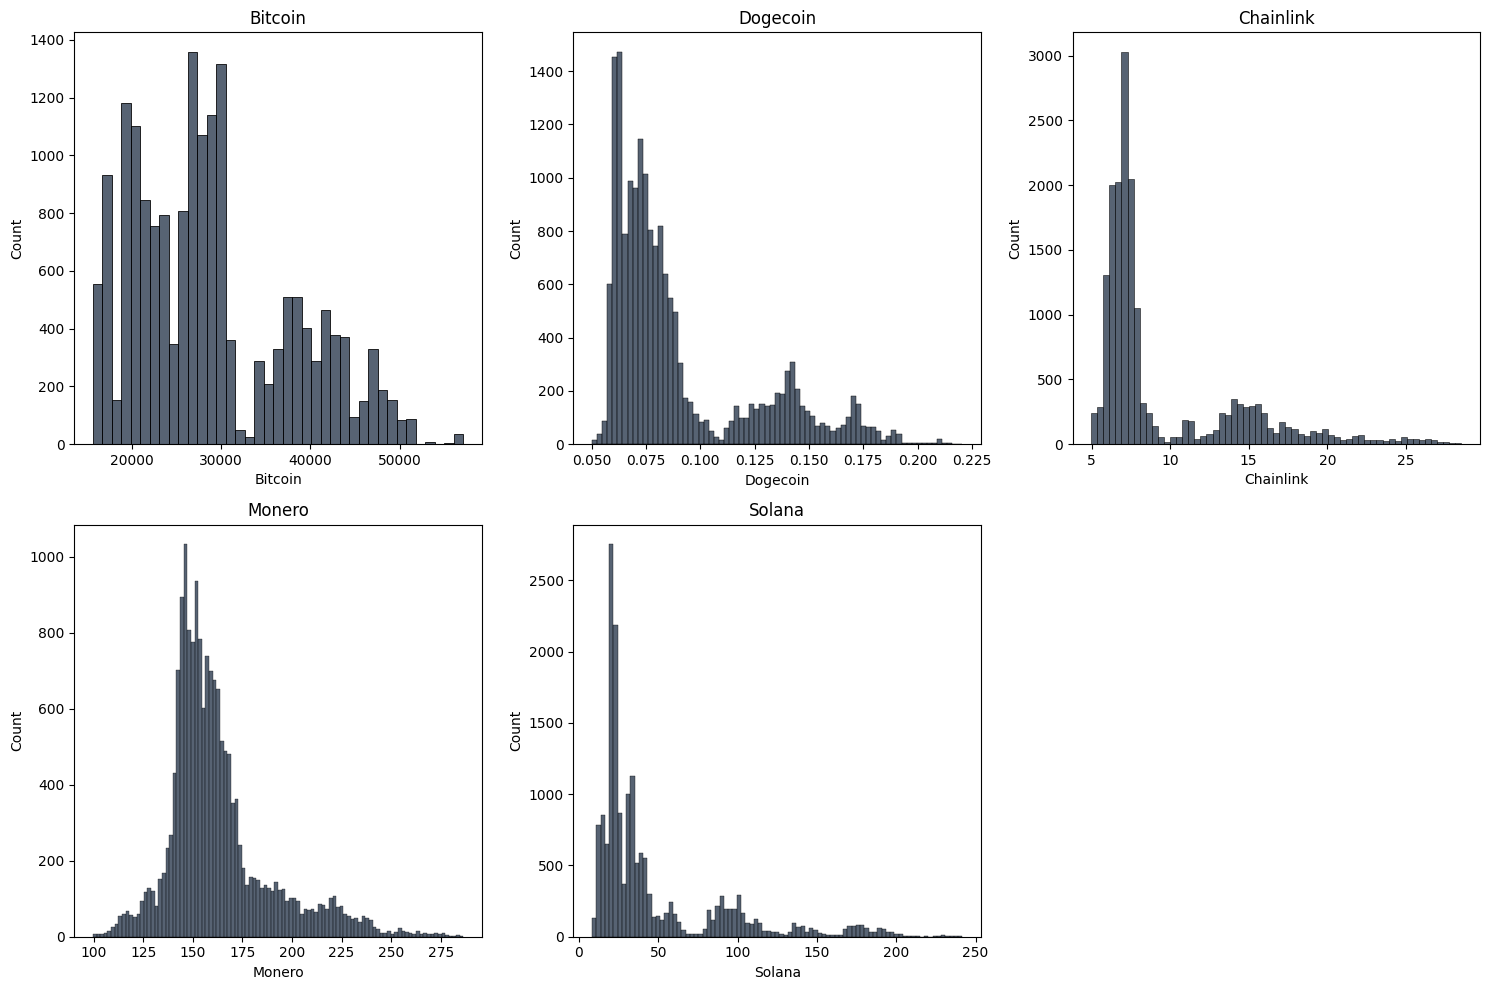

In [196]:
# Converter RGB para formato normalizado (0-1)
rgb_color = np.array([31, 47, 68]) / 255  # Normalizando valores RGB

# Definir número de colunas para os subplots
num_cols = len(criptos.columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Ajusta para múltiplas linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))  # Grid de 3 colunas
axes = axes.flatten()  # Transforma a matriz de eixos em um array 1D

# Gerar os histogramas para cada coluna com a cor definida
for i, column in enumerate(criptos.columns):
    sns.histplot(data=criptos, x=column, ax=axes[i], color=rgb_color)
    axes[i].set_title(f'{column}')

# Remover subplots vazios, caso o número de gráficos não seja múltiplo de 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout
plt.tight_layout()
plt.show()

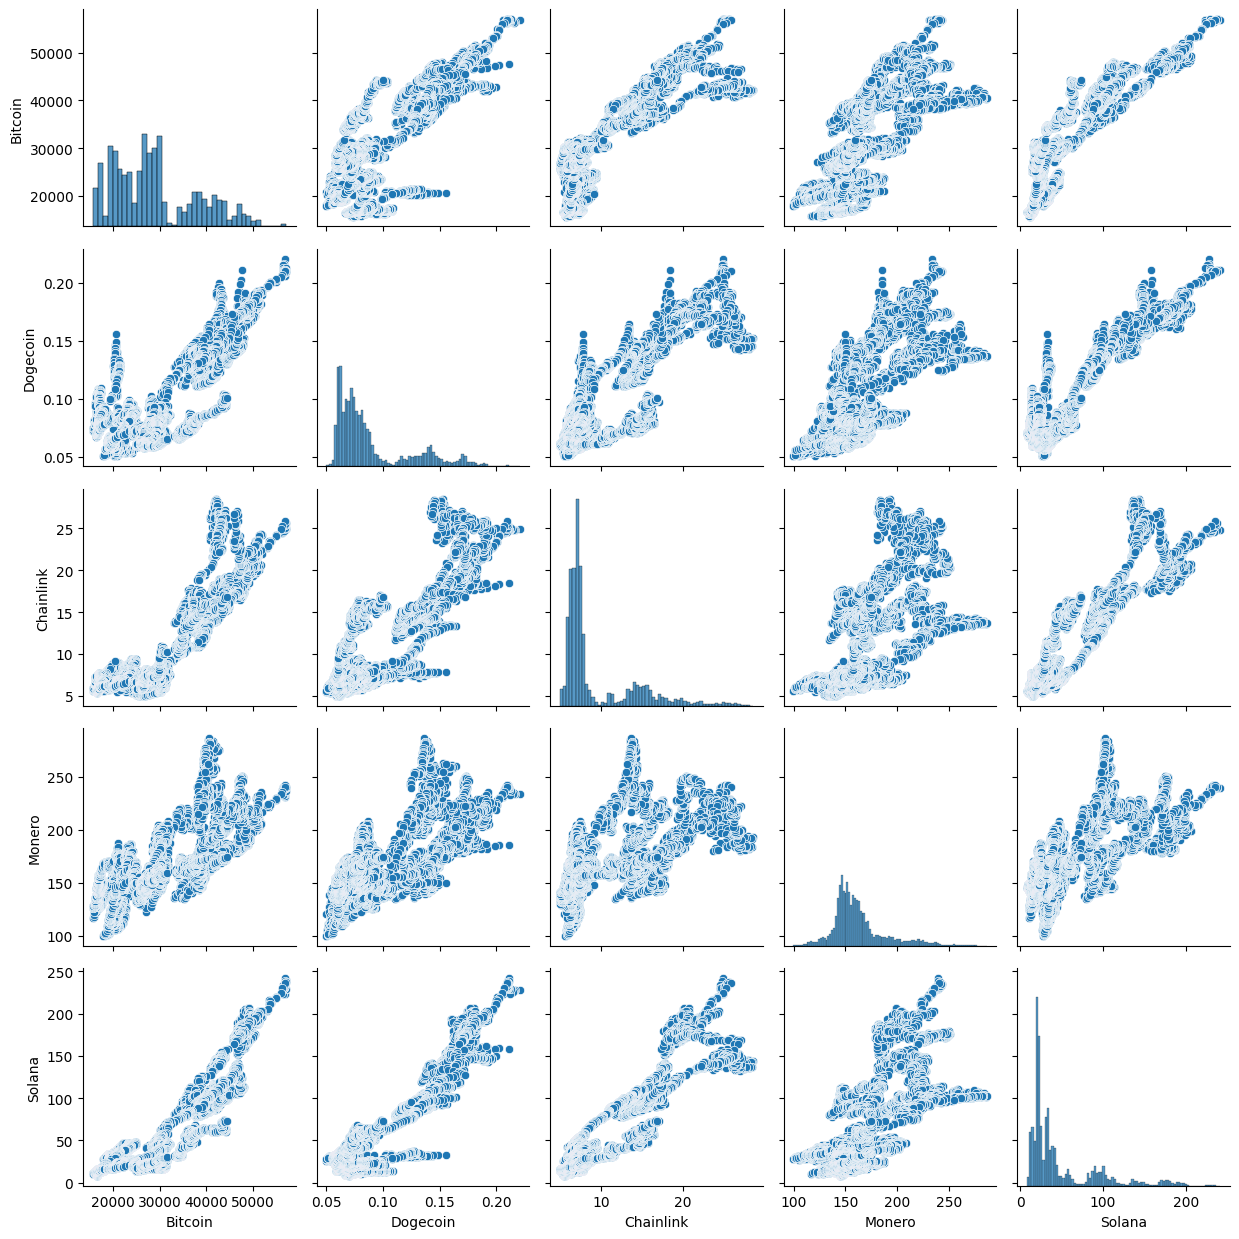

In [121]:
sns.pairplot(criptos)

plt.tight_layout()

In [122]:
criptos.corr()

Bitcoin  Dogecoin  Chainlink  Monero  Solana
Bitcoin       1.00      0.77       0.86    0.74    0.85
Dogecoin      0.77      1.00       0.86    0.71    0.90
Chainlink     0.86      0.86       1.00    0.66    0.93
Monero        0.74      0.71       0.66    1.00    0.70
Solana        0.85      0.90       0.93    0.70    1.00

In [123]:
criptos_diff = (criptos - criptos.shift(1)) / criptos.shift(1)

In [124]:
criptos_diff = criptos_diff.dropna()

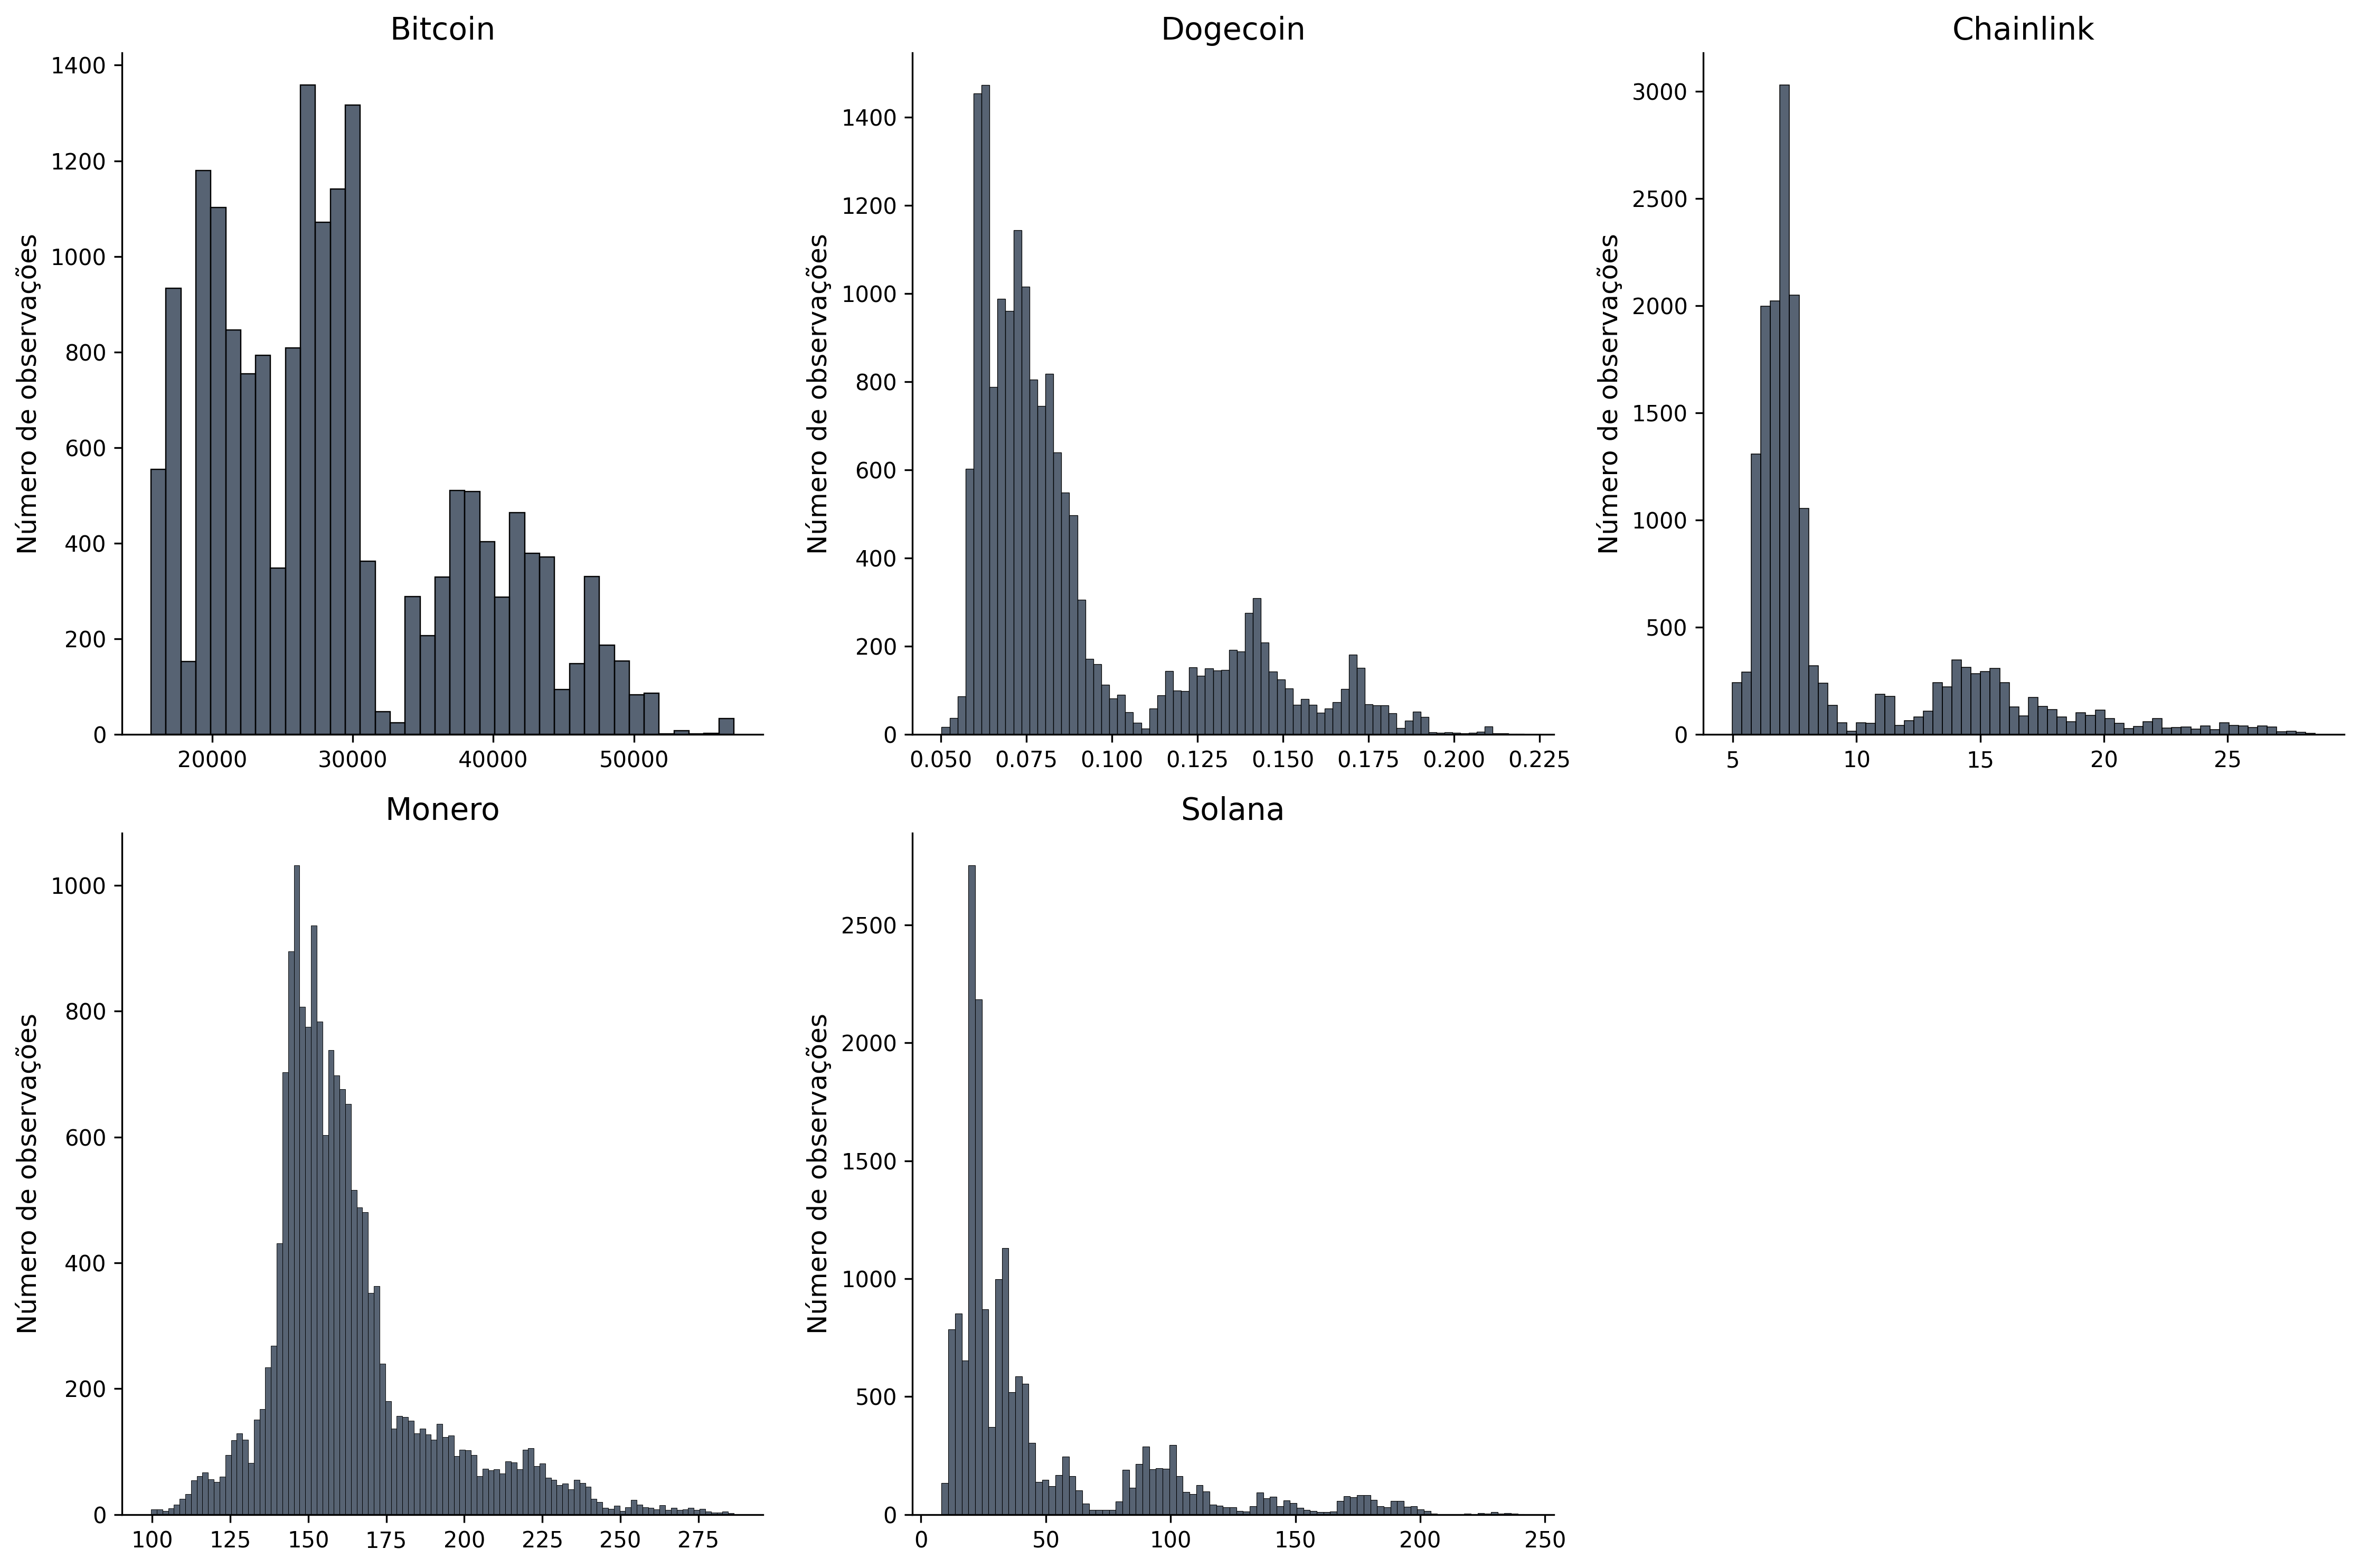

In [125]:
# Converter RGB para formato normalizado (0-1)
rgb_color = np.array([31, 47, 68]) / 255  # Normalizando valores RGB

# Criar pasta para salvar as imagens
output_folder = r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data"
os.makedirs(output_folder, exist_ok=True)

# Definir número de colunas para os subplots
num_cols = len(criptos.columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Ajusta para múltiplas linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), dpi=300)  # DPI alto para melhor qualidade
axes = axes.flatten()  # Transforma a matriz de eixos em um array 1D

# Gerar os histogramas para cada coluna com a cor definida
for i, column in enumerate(criptos.columns):
    sns.histplot(data=criptos, x=column, ax=axes[i], color=rgb_color)
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_ylabel('Número de observações', fontsize=12)
    axes[i].set_xlabel('', fontsize=12)

    # Remover bordas superiores e direitas
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Remover subplots vazios, caso o número de gráficos não seja múltiplo de 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

# Ajustar layout e salvar a imagem com qualidade alta
plt.tight_layout()
fig.savefig(os.path.join(output_folder, "criptos_histogramas.png"), dpi=300, bbox_inches="tight")  # Salvar com DPI alto
plt.show()

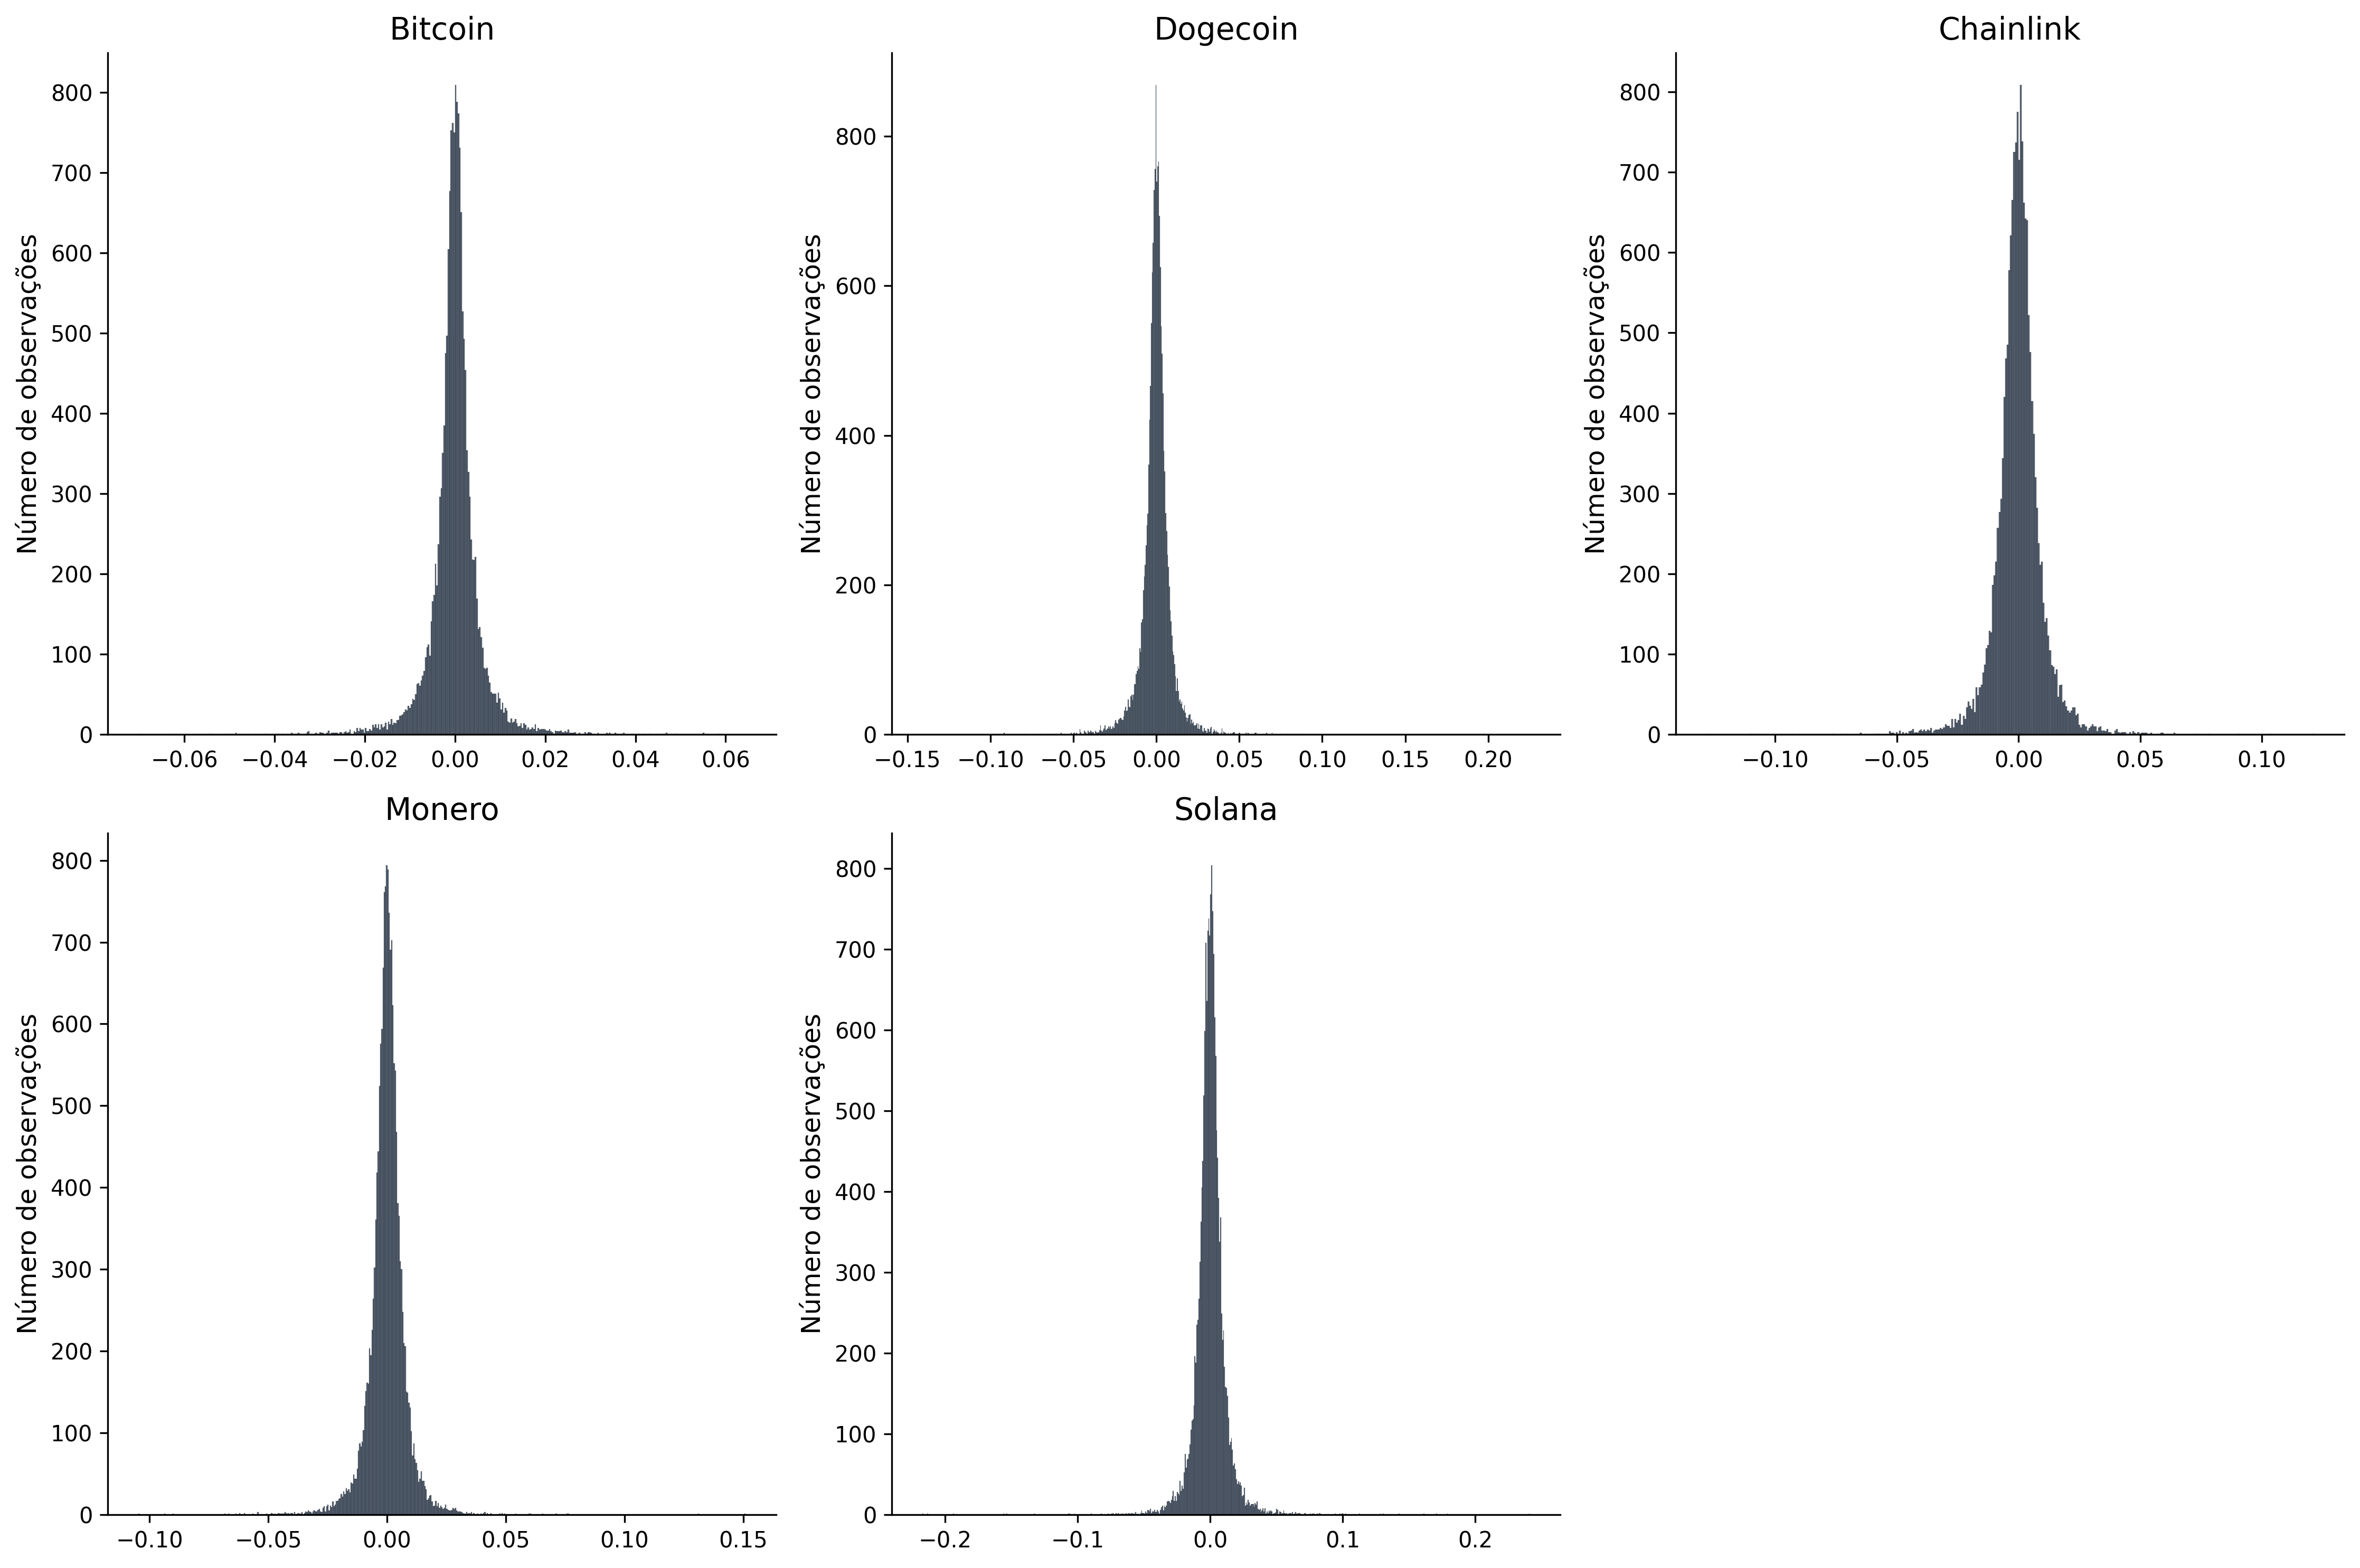

In [126]:
# Converter RGB para formato normalizado (0-1)
rgb_color = np.array([31, 47, 68]) / 255  # Normalizando valores RGB

# Criar pasta para salvar as imagens
output_folder = r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data"
os.makedirs(output_folder, exist_ok=True)

# Definir número de colunas para os subplots
num_cols = len(criptos_diff.columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Ajusta para múltiplas linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5  * num_rows), dpi=300)  # DPI alto para melhor qualidade
axes = axes.flatten()  # Transforma a matriz de eixos em um array 1D

# Gerar os histogramas para cada coluna com a cor definida
for i, column in enumerate(criptos.columns):
    sns.histplot(data=criptos_diff, x=column, ax=axes[i], color=rgb_color)
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_ylabel('Número de observações', fontsize=12)
    axes[i].set_xlabel('', fontsize=12)

    # Remover bordas superiores e direitas
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Remover subplots vazios, caso o número de gráficos não seja múltiplo de 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

# Ajustar layout e salvar a imagem com qualidade alta
plt.tight_layout()
fig.savefig(os.path.join(output_folder, "criptos_diff_histogramas.png"), dpi=300, bbox_inches="tight")  # Salvar com DPI alto
plt.show()

## Correlação

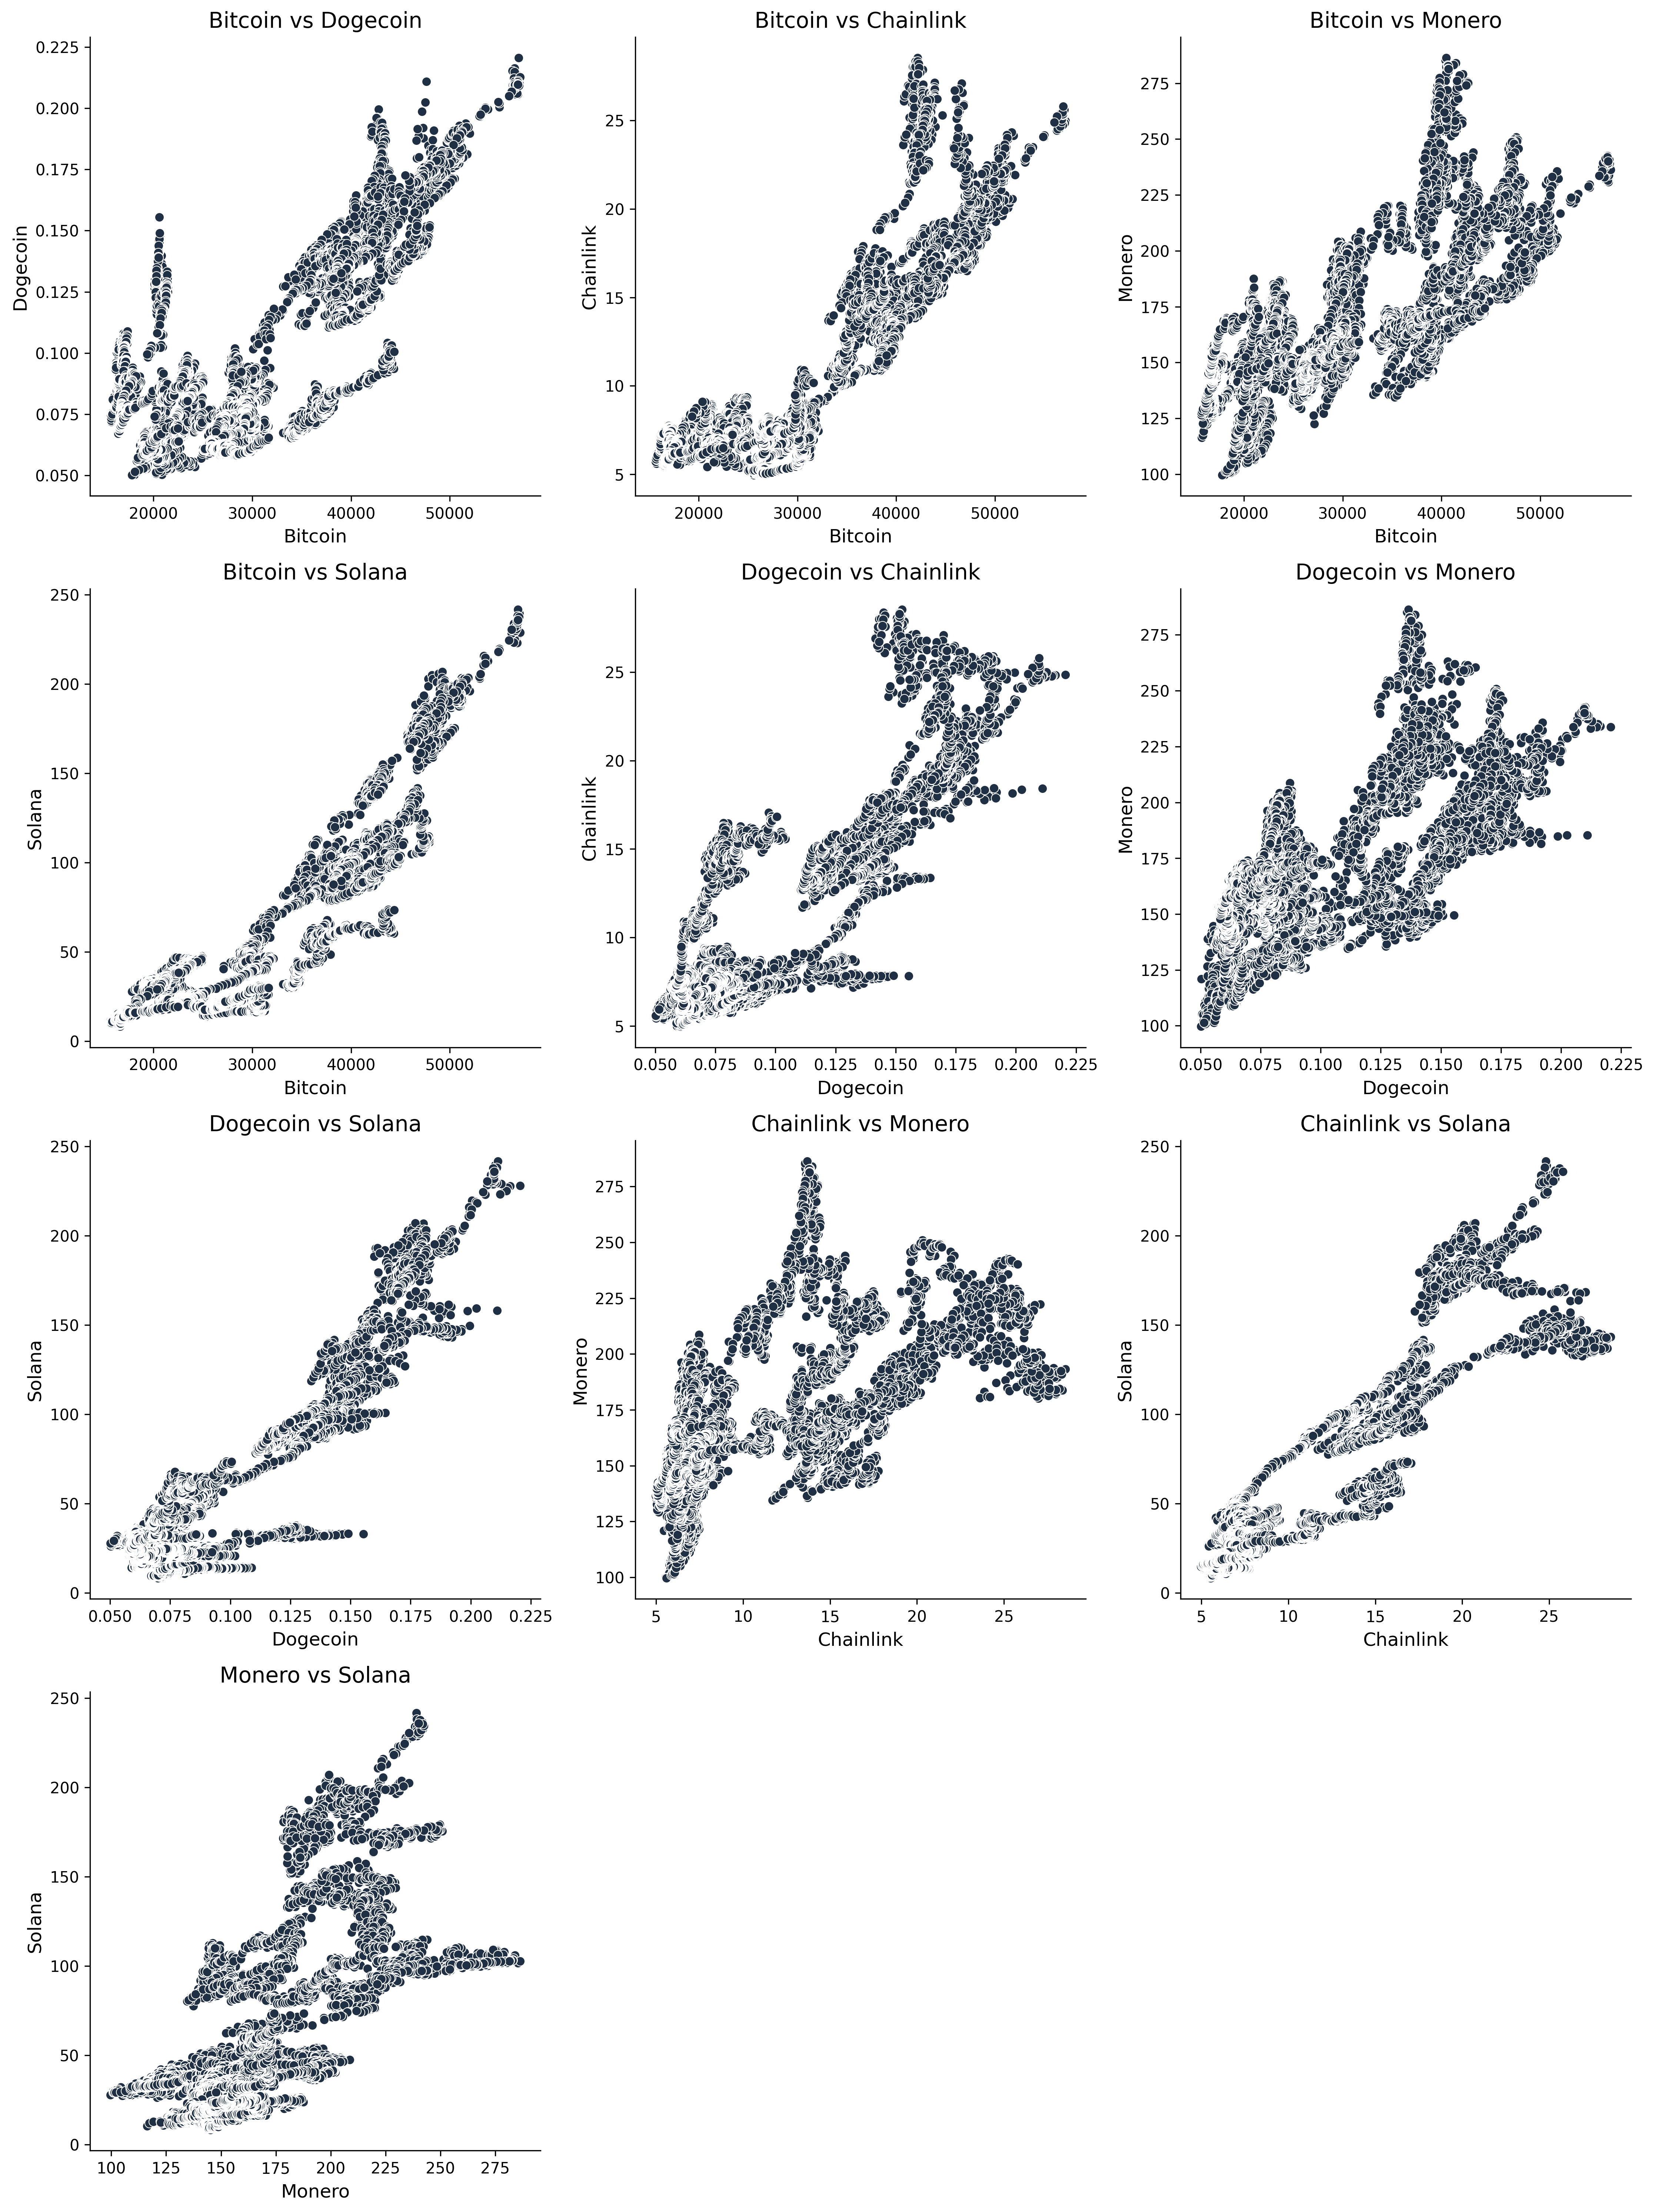

In [127]:
# Converter RGB para formato normalizado (0-1)
rgb_color = np.array([31, 47, 68]) / 255  # Normalizando valores RGB

# Criar pasta para salvar as imagens
output_folder = r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data"
os.makedirs(output_folder, exist_ok=True)

# Definir número de colunas para os subplots
num_cols = 3  # Número fixo de colunas
num_pairs = len(criptos.columns) * (len(criptos.columns) - 1) // 2  # Número total de combinações
num_rows = (num_pairs // num_cols) + (num_pairs % num_cols > 0)  # Ajuste para múltiplas linhas

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=300)  # DPI alto para melhor qualidade
axes = axes.flatten()  # Transforma a matriz de eixos em um array 1D

# Gerar os gráficos de dispersão para todas as combinações de pares
pair_idx = 0  # Índice para percorrer os pares
for i in range(len(criptos.columns)):
    for j in range(i + 1, len(criptos.columns)):
        sns.scatterplot(data=criptos, x=criptos.columns[i], y=criptos.columns[j], ax=axes[pair_idx], color=rgb_color)
        axes[pair_idx].set_title(f'{criptos.columns[i]} vs {criptos.columns[j]}', fontsize=14)
        axes[pair_idx].set_xlabel(criptos.columns[i], fontsize=12)  # Aumentando a fonte do rótulo do eixo X
        axes[pair_idx].set_ylabel(criptos.columns[j], fontsize=12)  # Aumentando a fonte do rótulo do eixo Y

        # Remover bordas superiores e direitas
        axes[pair_idx].spines['top'].set_visible(False)
        axes[pair_idx].spines['right'].set_visible(False)

        pair_idx += 1

# Remover subplots vazios, caso o número de gráficos não seja múltiplo de 3
for j in range(pair_idx, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout e salvar a imagem com qualidade alta
plt.tight_layout()
fig.savefig(os.path.join(output_folder, "criptos_scatter_pairs_all.png"), dpi=300, bbox_inches="tight")  # Salvar com DPI alto
plt.show()

In [128]:
criptos_diff.corr()

Bitcoin  Dogecoin  Chainlink  Monero  Solana
Bitcoin       1.00      0.64       0.75    0.63    0.69
Dogecoin      0.64      1.00       0.65    0.53    0.60
Chainlink     0.75      0.65       1.00    0.62    0.69
Monero        0.63      0.53       0.62    1.00    0.54
Solana        0.69      0.60       0.69    0.54    1.00

## Correlations with lags

In [129]:
series_dict = {
    'Bitcoin': criptos['Bitcoin'],
    'DogeCoin': criptos['Dogecoin'],
    'Chainlink': criptos['Chainlink'],
    'Monero': criptos['Monero'],
    'Solana': criptos['Solana']
}

In [130]:
series_dict_diff = {
    'Bitcoin': criptos_diff['Bitcoin'],
    'DogeCoin': criptos_diff['Dogecoin'],
    'Chainlink': criptos_diff['Chainlink'],
    'Monero': criptos_diff['Monero'],
    'Solana': criptos_diff['Solana']
}

### Bitcoin

In [131]:
correlation_with_lags(criptos['Bitcoin'], series_dict, max_lag = 200)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          1.00        1.00        1.00        1.00        1.00   
DogeCoin         0.77        0.77        0.77        0.77        0.77   
Chainlink        0.86        0.86        0.86        0.86        0.86   
Monero           0.74        0.74        0.74        0.74        0.74   
Solana           0.85        0.85        0.85        0.85        0.85   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  ...  \
Bitcoin          1.00        1.00        1.00        1.00        1.00  ...   
DogeCoin         0.77        0.77        0.77        0.77        0.77  ...   
Chainlink        0.86        0.86        0.86        0.86        0.86  ...   
Monero           0.74        0.74        0.74        0.74        0.74  ...   
Solana           0.85        0.85        0.85        0.85        0.85  ...   

           corr_lag_191  corr_lag_192  corr_lag_193  corr_lag_194  \
Bitcoin            0.96          0.96          0.96          0.96   
DogeCoin           0.71          0.71          0.71          0.71   
Chainlink          0.81          0.81          0.81          0.81   
Monero             0.65          0.65          0.65          0.65   
Solana             0.80          0.80          0.80          0.80   

           corr_lag_195  corr_lag_196  corr_lag_197  corr_lag_198  \
Bitcoin            0.96          0.96          0.96          0.96   
DogeCoin           0.71          0.71          0.71          0.71   
Chainlink          0.81          0.81          0.81          0.81   
Monero             0.64          0.64          0.64          0.64   
Solana             0.79          0.79          0.79          0.79   

           corr_lag_199  corr_lag_200  
Bitcoin            0.96          0.96  
DogeCoin           0.71          0.71  
Chainlink          0.81          0.81  
Monero             0.64          0.64  
Solana             0.79          0.79  

[5 rows x 201 columns]

In [132]:
correlation_with_lags(criptos_diff['Bitcoin'], series_dict_diff, max_lag = 200)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          1.00       -0.00        0.00       -0.00       -0.00   
DogeCoin         0.64        0.00       -0.00       -0.01        0.01   
Chainlink        0.75        0.01        0.00       -0.02        0.01   
Monero           0.63        0.01        0.01       -0.00        0.02   
Solana           0.69        0.03        0.01        0.00        0.00   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  ...  \
Bitcoin          0.00        0.01       -0.02        0.01        0.01  ...   
DogeCoin         0.00       -0.00       -0.01        0.01        0.00  ...   
Chainlink        0.00        0.01       -0.02        0.02       -0.00  ...   
Monero           0.02        0.01       -0.02        0.02        0.00  ...   
Solana          -0.01        0.00       -0.01        0.02        0.01  ...   

           corr_lag_191  corr_lag_192  corr_lag_193  corr_lag_194  \
Bitcoin            0.00          0.00         -0.01          0.01   
DogeCoin           0.00         -0.00         -0.01          0.00   
Chainlink         -0.01         -0.00         -0.01          0.01   
Monero             0.00         -0.01          0.00          0.01   
Solana            -0.00         -0.01         -0.01          0.01   

           corr_lag_195  corr_lag_196  corr_lag_197  corr_lag_198  \
Bitcoin           -0.02          0.01         -0.01         -0.00   
DogeCoin          -0.02         -0.01          0.00         -0.01   
Chainlink         -0.02         -0.00         -0.00          0.00   
Monero            -0.02          0.00         -0.00         -0.01   
Solana            -0.02         -0.01         -0.00         -0.00   

           corr_lag_199  corr_lag_200  
Bitcoin            0.00         -0.00  
DogeCoin           0.00         -0.01  
Chainlink          0.01         -0.00  
Monero             0.01         -0.00  
Solana             0.01          0.00  

[5 rows x 201 columns]

### Dogecoin

In [133]:
correlation_with_lags(criptos['Dogecoin'], series_dict, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.77        0.77        0.77        0.77        0.77   
DogeCoin         1.00        1.00        1.00        1.00        1.00   
Chainlink        0.86        0.86        0.86        0.86        0.86   
Monero           0.71        0.71        0.71        0.71        0.71   
Solana           0.90        0.90        0.90        0.90        0.90   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin          0.77        0.77        0.77        0.77        0.77   
DogeCoin         1.00        1.00        1.00        1.00        1.00   
Chainlink        0.86        0.86        0.86        0.86        0.86   
Monero           0.71        0.71        0.71        0.71        0.71   
Solana           0.90        0.90        0.90        0.90        0.90   

           corr_lag_10  
Bitcoin           0.77  
DogeCoin          1.00  
Chainlink         0.86  
Monero            0.71  
Solana            0.90

In [134]:
correlation_with_lags(criptos_diff['Dogecoin'], series_dict_diff, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.64       -0.02       -0.01       -0.01       -0.00   
DogeCoin         1.00       -0.01       -0.03       -0.02        0.00   
Chainlink        0.65       -0.01       -0.01       -0.02        0.02   
Monero           0.53       -0.02        0.01       -0.02        0.01   
Solana           0.60        0.01       -0.00       -0.01        0.01   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin         -0.01       -0.01       -0.02        0.03        0.00   
DogeCoin        -0.00        0.00       -0.01        0.02        0.00   
Chainlink       -0.00       -0.01       -0.02        0.02        0.00   
Monero           0.01       -0.00       -0.02        0.03        0.00   
Solana          -0.02       -0.01       -0.01        0.03        0.00   

           corr_lag_10  
Bitcoin          -0.00  
DogeCoin         -0.01  
Chainlink        -0.01  
Monero           -0.00  
Solana           -0.00

### ChainLink

In [135]:
correlation_with_lags(criptos['Chainlink'], series_dict, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.86        0.86        0.86        0.86        0.86   
DogeCoin         0.86        0.86        0.86        0.86        0.86   
Chainlink        1.00        1.00        1.00        1.00        1.00   
Monero           0.66        0.66        0.66        0.66        0.66   
Solana           0.93        0.93        0.93        0.93        0.93   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin          0.86        0.86        0.86        0.86        0.86   
DogeCoin         0.86        0.86        0.86        0.86        0.86   
Chainlink        1.00        1.00        1.00        1.00        1.00   
Monero           0.66        0.66        0.66        0.66        0.66   
Solana           0.93        0.93        0.92        0.92        0.92   

           corr_lag_10  
Bitcoin           0.86  
DogeCoin          0.86  
Chainlink         1.00  
Monero            0.66  
Solana            0.92

In [136]:
correlation_with_lags(criptos_diff['Chainlink'], series_dict_diff, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.75       -0.02       -0.01       -0.01       -0.01   
DogeCoin         0.65       -0.01       -0.02       -0.02       -0.00   
Chainlink        1.00       -0.01       -0.00       -0.02        0.01   
Monero           0.62       -0.02       -0.00       -0.02        0.01   
Solana           0.69        0.02       -0.01       -0.01        0.01   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin         -0.01       -0.00       -0.02        0.02       -0.00   
DogeCoin        -0.01       -0.01       -0.02        0.02        0.00   
Chainlink       -0.00        0.00       -0.03        0.03       -0.01   
Monero          -0.00        0.00       -0.03        0.03       -0.01   
Solana          -0.02       -0.00       -0.02        0.02        0.00   

           corr_lag_10  
Bitcoin          -0.01  
DogeCoin         -0.01  
Chainlink        -0.01  
Monero           -0.01  
Solana           -0.00

### Monero

In [137]:
correlation_with_lags(criptos['Monero'], series_dict, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.74        0.74        0.74        0.74        0.74   
DogeCoin         0.71        0.71        0.71        0.71        0.71   
Chainlink        0.66        0.66        0.66        0.66        0.66   
Monero           1.00        1.00        1.00        1.00        1.00   
Solana           0.70        0.70        0.70        0.70        0.70   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin          0.74        0.74        0.74        0.74        0.74   
DogeCoin         0.71        0.71        0.71        0.71        0.71   
Chainlink        0.66        0.66        0.66        0.66        0.66   
Monero           0.99        0.99        0.99        0.99        0.99   
Solana           0.70        0.70        0.70        0.70        0.70   

           corr_lag_10  
Bitcoin           0.74  
DogeCoin          0.71  
Chainlink         0.66  
Monero            0.99  
Solana            0.70

In [138]:
correlation_with_lags(criptos_diff['Monero'], series_dict_diff, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.63       -0.02       -0.03       -0.01       -0.00   
DogeCoin         0.53       -0.03       -0.02       -0.01       -0.00   
Chainlink        0.62       -0.02       -0.02       -0.03        0.01   
Monero           1.00       -0.02       -0.02       -0.02        0.01   
Solana           0.54       -0.01       -0.01       -0.01        0.01   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin         -0.00        0.00       -0.01        0.02        0.01   
DogeCoin        -0.00       -0.01       -0.00        0.02        0.00   
Chainlink       -0.00       -0.00       -0.01        0.02       -0.00   
Monero          -0.00        0.00       -0.02        0.03       -0.02   
Solana          -0.02        0.00       -0.01        0.02        0.01   

           corr_lag_10  
Bitcoin           0.01  
DogeCoin          0.00  
Chainlink         0.00  
Monero            0.01  
Solana            0.01

### Solana

In [139]:
correlation_with_lags(criptos['Solana'], series_dict, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.85        0.85        0.85        0.85        0.85   
DogeCoin         0.90        0.90        0.90        0.90        0.90   
Chainlink        0.93        0.93        0.93        0.93        0.93   
Monero           0.70        0.70        0.70        0.70        0.70   
Solana           1.00        1.00        1.00        1.00        1.00   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin          0.85        0.85        0.85        0.85        0.85   
DogeCoin         0.90        0.90        0.90        0.90        0.90   
Chainlink        0.93        0.93        0.93        0.93        0.93   
Monero           0.70        0.70        0.70        0.70        0.70   
Solana           1.00        1.00        1.00        1.00        1.00   

           corr_lag_10  
Bitcoin           0.85  
DogeCoin          0.90  
Chainlink         0.93  
Monero            0.70  
Solana            1.00

In [140]:
correlation_with_lags(criptos_diff['Solana'], series_dict_diff, max_lag = 10)

corr_lag_0  corr_lag_1  corr_lag_2  corr_lag_3  corr_lag_4  \
Bitcoin          0.69       -0.03       -0.01       -0.01       -0.01   
DogeCoin         0.60       -0.02       -0.01       -0.01       -0.00   
Chainlink        0.69       -0.01       -0.01       -0.02        0.01   
Monero           0.54       -0.02        0.01       -0.01        0.01   
Solana           1.00        0.00       -0.02       -0.00       -0.01   

           corr_lag_5  corr_lag_6  corr_lag_7  corr_lag_8  corr_lag_9  \
Bitcoin          0.00       -0.00       -0.02        0.02       -0.01   
DogeCoin        -0.01       -0.02       -0.01        0.03       -0.02   
Chainlink       -0.00       -0.01       -0.02        0.03       -0.02   
Monero          -0.00       -0.01       -0.02        0.04       -0.02   
Solana          -0.01       -0.02       -0.03        0.06        0.01   

           corr_lag_10  
Bitcoin           0.00  
DogeCoin          0.01  
Chainlink         0.01  
Monero            0.01  
Solana           -0.00

## AR model

### Stationarity

In [141]:
criptos.duplicated().sum()

np.int64(3)

#### Original series

In [142]:
check_stationarity(criptos['Bitcoin'])

ADF Statistic: -2.6381900759604924
p-value: 0.08535820075503625
A série não é estacionária (p > 0.05)


#### Diff series

In [143]:
check_stationarity(criptos_diff['Bitcoin'])

ADF Statistic: -23.927826818441524
p-value: 0.0
A série é estacionária (p <= 0.05)


## AR Models

First, we are going to apply the AR model to every time series with itself

## Autocorrelation

In [144]:
N_LAGS = 1000

### ACF

In [197]:
autocorrelation(df = criptos, n_lags = N_LAGS, autocorrelation_function= "ACF")

Autocorrelação salva no arquivo C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\Autocorrelação\ACF_function.xlsx


In [200]:
autocorrelation(df = criptos_diff, n_lags = N_LAGS, autocorrelation_function= "ACF", 
                output_file = r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\Autocorrelação\ACF_function_diff.xlsx")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Caio\\Documents\\Documentos\\IC - Cripto\\output_data\\Autocorrelação\\ACF_function_diff.xlsx'

In [ ]:
plot_autocorrelation(df = criptos, n_lags = N_LAGS, autocorrelation_function = 'ACF')

In [ ]:
plot_autocorrelation(df = criptos_diff, n_lags = N_LAGS, autocorrelation_function = 'ACF')

### PACF

In [ ]:
plot_autocorrelation(df = criptos_diff, n_lags = N_LAGS, autocorrelation_function = 'PACF')

## Creating the models

In [268]:
LAGS = [1]
STARTING_POINT = 0.8

In [269]:
performance, residuals, estimates = fit_ar_model(criptos_diff, starting_point_percent = STARTING_POINT, lags_list = LAGS)

Treinando para 1 lags
Treinando com a variável: Bitcoin
Treinando modelo AR com 1 lags
MSE: 0.0000
MAE: 0.0023
MSE: 0.0000
MAE: 0.0035
Treinando com a variável: Dogecoin
Treinando modelo AR com 1 lags
MSE: 0.0000
MAE: 0.0042
MSE: 0.0001
MAE: 0.0062
Treinando com a variável: Chainlink
Treinando modelo AR com 1 lags
MSE: 0.0001
MAE: 0.0056
MSE: 0.0001
MAE: 0.0084
Treinando com a variável: Monero
Treinando modelo AR com 1 lags
MSE: 0.0000
MAE: 0.0031
MSE: 0.0000
MAE: 0.0046
Treinando com a variável: Solana
Treinando modelo AR com 1 lags
MSE: 0.0001
MAE: 0.0062
MSE: 0.0002
MAE: 0.0092


ValueError: Must pass 2-d input. shape=(5, 3536, 2)

In [244]:
estimates.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\estimates\ar_estimates_table.xlsx")

In [69]:
performance.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_performance_table.xlsx")

In [70]:
performance

MSE       MAE
Variable        Lags                    
Bitcoin         1     0.000015  0.002280
Naive_Bitcoin   1     0.000033  0.003503
Dogecoin        1     0.000046  0.004165
Naive_Dogecoin  1     0.000096  0.006202
Chainlink       1     0.000071  0.005637
Naive_Chainlink 1     0.000145  0.008377
Monero          1     0.000019  0.003054
Naive_Monero    1     0.000041  0.004565
Solana          1     0.000089  0.006219
Naive_Solana    1     0.000181  0.009236

In [71]:
residuals

Variable              Bitcoin  Dogecoin Chainlink    Monero    Solana
Lags                        1         1         1         1         1
date_hour                                                            
2023-07-14 10:00:00 -0.001330 -0.000647  0.002319  0.006853 -0.005416
2023-07-14 11:00:00  0.001815 -0.026154 -0.005660  0.000447 -0.003939
2023-07-14 12:00:00  0.000994  0.013188  0.008348  0.009430  0.025374
2023-07-14 13:00:00  0.017147  0.027969  0.018621  0.016740  0.011516
2023-07-14 14:00:00  0.019151  0.033155  0.028205  0.016339  0.042167
...                       ...       ...       ...       ...       ...
2023-12-08 12:00:00 -0.001385 -0.004534  0.004814 -0.001016 -0.012640
2023-12-08 13:00:00  0.001969 -0.000338 -0.005122 -0.000588 -0.010829
2023-12-08 14:00:00 -0.001604 -0.002230  0.005806  0.001157  0.011830
2023-12-08 15:00:00 -0.003247 -0.016950 -0.010479  0.000618  0.006607
2023-12-08 16:00:00 -0.009378 -0.003635 -0.003430 -0.008070 -0.015343

[3535 rows x 5 columns]

## Adding exogenous variables

In [277]:
performance_exog, residuals_exog, estimates_exog = fit_ar_model_exog(df = criptos_diff, target_column = 'Bitcoin', starting_point_percent = STARTING_POINT, lags_list = LAGS)

Treinando para 1 lags
Treinando com variáveis exógenas: ('Dogecoin',)
Treinando modelo AR com variáveis exógenas e lags
Modelo ajustado
Predição passo 1
Predição passo 2
Predição passo 3
Predição passo 4
Predição passo 5
Predição passo 6
Predição passo 7
Predição passo 8
Predição passo 9
Predição passo 10
Predição passo 11
Predição passo 12
Predição passo 13
Predição passo 14
Predição passo 15
Predição passo 16
Predição passo 17
Predição passo 18
Predição passo 19
Predição passo 20
Predição passo 21
Predição passo 22
Predição passo 23
Predição passo 24
Predição passo 25
Predição passo 26
Predição passo 27
Predição passo 28
Predição passo 29
Predição passo 30
Predição passo 31
Predição passo 32
Predição passo 33
Predição passo 34
Predição passo 35
Predição passo 36
Predição passo 37
Predição passo 38
Predição passo 39
Predição passo 40
Predição passo 41
Predição passo 42
Predição passo 43
Predição passo 44
Predição passo 45
Predição passo 46
Predição passo 47
Predição passo 48
Predição 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (15, 3536) + inhomogeneous part.

In [ ]:
estimates_exog.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\Estimates\ar_exog_estimates_table.xlsx")

In [ ]:
performance_exog.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_exog_performance_table.xlsx")

In [ ]:
performance_exog

## Using logs

In [ ]:
criptos_log = np.log(criptos)

In [ ]:
criptos_log_diff = criptos_log - criptos_log.shift(1)
criptos_log_diff = criptos_log_diff.dropna()

In [ ]:
criptos_diff

In [ ]:
criptos_log_diff

### Simple AR(1) models

In [ ]:
performance_log, residuals_log = fit_ar_model(criptos_log_diff, starting_point_percent = STARTING_POINT, lags_list = LAGS)

In [ ]:
performance_log.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_log_performance_table.xlsx")

### Exogenous

In [ ]:
performance_exog_log, residuals_exog_log = fit_ar_model_exog(df = criptos_log_diff, target_column = 'Bitcoin', starting_point_percent = STARTING_POINT, lags_list = LAGS)

In [ ]:
performance_exog_log.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\ar_exog_log_performance_table.xlsx")

In [ ]:
performance_exog_log

## Residual analysis

In [ ]:
residuals = residuals.iloc[:,:5]

In [ ]:
residuals_exog =  residuals_exog.iloc[:, :4]

In [ ]:
residuals_exog_log = residuals_exog_log.iloc[:, :4]

### Scatter plot

In [ ]:
sns.pairplot(residuals)

plt.tight_layout()

In [ ]:
sns.pairplot(residuals_exog)

plt.tight_layout()

In [ ]:
sns.pairplot(residuals_log)

plt.tight_layout()

In [ ]:
residuals_log.corr()

In [ ]:
sns.pairplot(residuals_exog_log)

plt.tight_layout()

### Time

In [ ]:
plot_residuals(residuals)

In [ ]:
plot_residuals(residuals_exog)

In [ ]:
plot_residuals(residuals_log)

In [ ]:
plot_residuals(residuals_exog_log)

## ML models

## Model validation

In [88]:
decision_tree = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "splitter": ["best"],
            "max_depth": [int(3), int(5), int(10), int(50)],
            "min_samples_split": [int(2), int(5),  int(50)],
            "min_samples_leaf": [int(1), int(2), int(10)],
            "max_features": ["sqrt"],
            "max_leaf_nodes": [int(10), int(20), int(50), int(100)],
        }
    }}

In [89]:
rf = {"Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [int(100), int(200), int(500)],
            "max_depth": [int(5), int(30), int(50)],
            "min_samples_split": [int(2), int(5), int(20)],
            "min_samples_leaf": [int(1), int(3), int(6)],
            "bootstrap": [False],  
            "oob_score": [False],
        }
    }}

In [90]:
xgb = {"XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [int(100), int(200), int(500)],
            "max_depth": [int(3), int(10), int(15)],
            "learning_rate": [0.001, 0.01, 0.1],
            "subsample": [0.7, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.9, 1.0],
            "gamma": [0.1, 0.2, 0.3],
            "reg_alpha": [0.1, 0.5, 1],
            "reg_lambda": [0.1, 0.5, 1],
            "min_child_weight": [int(1), int(3), int(5)]
        }
}}

## 1 lag models

In [93]:
one_lag_results_tree = optimize_and_evaluate_one_lag(criptos_diff, decision_tree)


🔍 Processing column: Bitcoin
⚙️ Optimizing model: Decision Tree for Bitcoin
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Total training time: 0.13 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Total training time: 0.12 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 50, 'splitter': 'best'}
Total training time: 0.11 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Total training time: 0.12 seconds
Testando a combinação {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Total training time: 0.11 

In [94]:
one_lag_results.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_tree_ml.xlsx")

In [ ]:
one_lag_results_rf = optimize_and_evaluate_one_lag(criptos_diff, rf)


🔍 Processing column: Bitcoin
⚙️ Optimizing model: Random Forest for Bitcoin
Testando a combinação {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False}
Total training time: 11.39 seconds
Testando a combinação {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': False}
Total training time: 22.70 seconds
Testando a combinação {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'oob_score': False}
Total training time: 56.34 seconds
Testando a combinação {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'oob_score': False}
Total training time: 11.46 seconds
Testando a combinação {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': False}
Total training time: 22.44 seconds
Testando a co

In [ ]:
one_lag_results_rf.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_rf_ml.xlsx")

In [ ]:
one_lag_results_xgb = optimize_and_evaluate_one_lag(criptos_diff, xgb)

In [ ]:
one_lag_results_xgb.to_excel(r"C:\Users\Caio\Documents\Documentos\IC - Cripto\output_data\results_xgb_ml.xlsx")

## Adding exogenous variables

In [ ]:
best_results = results_df.sort_values(by="mse").groupby("model").first().reset_index()
print(best_results)